## Importing Data Via API

In [2]:
from urllib.request import urlopen
import json
import pandas as pd

resource_id = 'd2528cf9-09a0-4666-9998-3667fe420675'
url = f'https://www.data.brisbane.qld.gov.au/data/api/3/action/datastore_search?resource_id={resource_id}&limit=999999999'

with urlopen(url) as response:
    data = response.read()

json_data = json.loads(data)

records = json_data['result']['records']

apidf = pd.DataFrame(records)

apidf.shape

(32000, 11)

## Because the API caps data at 32000 rows, two randomly chosen CSVs will be combined for random sampling

In [3]:


df2 = pd.read_csv('LibraryCheckoutsallBranchesJanuary2020.csv', encoding= 'latin1')
df3 = pd.read_csv('Library Checkouts all Branches December 2021.csv', encoding = 'latin1')
df = pd.concat([df2,df3])

df_copy = df.copy()

In [4]:
df.info()
print('---')
print(df.shape)
print('---')
df.head(5)

<class 'pandas.core.frame.DataFrame'>
Index: 145376 entries, 0 to 61087
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Title             145376 non-null  object
 1   Author            115358 non-null  object
 2   Call Number       145376 non-null  object
 3   Item Id           145376 non-null  object
 4   Item Type         84288 non-null   object
 5   Status            145376 non-null  object
 6   Language          3331 non-null    object
 7   Age               145376 non-null  object
 8   Checkout Library  145376 non-null  object
 9   Date              145376 non-null  int64 
 10  Item Type Code    61088 non-null   object
dtypes: int64(1), object(10)
memory usage: 13.3+ MB
---
(145376, 11)
---


,Title,Author,Call Number,Item Id,Item Type,Status,Language,Age,Checkout Library,Date,Item Type Code
0,'--And a Happy New Year? /,"Bourne, Holly,",YA-FICTION BOU,34000101703072,YA-FICTION,CHECKEDOUT,NaN,YA,GNG,20200107204214,NaN
1,'A' is for alibi /,"Grafton, Sue.",AD-PBK GRA,34000108104274,AD-PBK,CHECKEDOUT,NaN,ADULT,CNL,20200107103320,NaN
2,'C' is for corpse /,"Grafton, Sue",AD-PBK GRA,34000053593497,AD-PBK,CHECKEDOUT,NaN,ADULT,BNO,20200107141732,NaN
3,'Salem's Lot /,"King, Stephen,",AD-PBK KIN,34000101691608,AD-PBK,CHECKEDOUT,NaN,ADULT,BSQ,20200107104314,NaN
4,'Salem's Lot /,"King, Stephen,",AD-PBK KIN,34000106233315,AD-PBK,CHECKEDOUT,NaN,ADULT,BSQ,20200107100341,NaN


## Cleaning

In [5]:
df['Language'] = df['Language'].fillna('ENGLISH') 

In [6]:
df['Title'] = df['Title'].str.rstrip('/')
df['Author'] = df['Author'].str.rstrip('./,') #stripping unwanted characters
df['Title'] = df['Title'].str.replace('FASTBACK -', '')

In [7]:
df.drop('Status', axis= 1, inplace= True) #dropping Status as every row in dataframe is checked out, redundant  

In [8]:
df['Date'] = pd.to_datetime(df['Date'], format='%Y%m%d%H%M%S') #datetime

# df['Date'] = df['Date'].dt.time

# df['Date'] = pd.to_datetime(df['Date'], format='%H:%M:%S')

# df['Date']


## Analysis

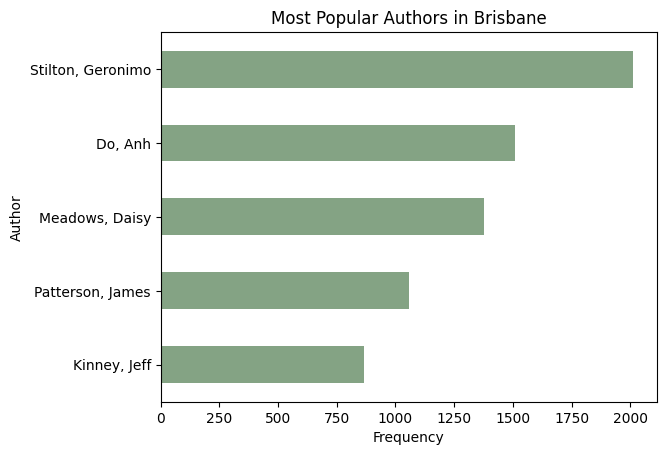

In [142]:
import matplotlib.pyplot as plt

color = (0.2, # redness
         0.4, # greenness
         0.2, # blueness
         0.6 # transparency
         ) 

ax = df['Author'].value_counts()\
                    .head(5)\
                    .plot(kind= 'barh', 
                         title='Most Popular Authors in Brisbane',
                         color= color)

ax.invert_yaxis()

ax.set_xlabel('Frequency')

plt.show()

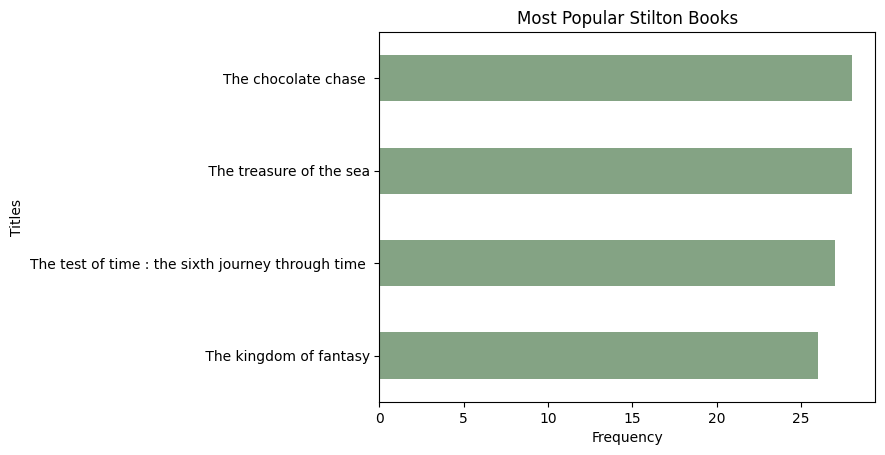

In [143]:
Geronimo = df.loc[df['Author'] == 'Stilton, Geronimo']
Geronimo = Geronimo['Title'].value_counts()\
                .head(4)\
                .plot(kind='barh',
                      title='Most Popular Stilton Books',
                      color= color)
Geronimo.invert_yaxis()
Geronimo.set_xlabel('Frequency')
Geronimo.set_ylabel('Titles')
plt.show()

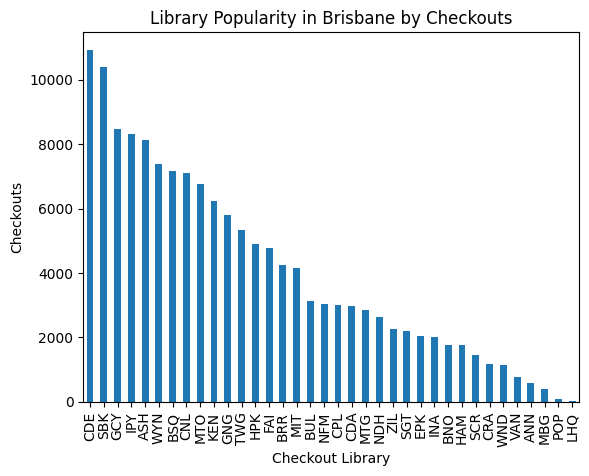

In [11]:
libraries = df['Checkout Library'].value_counts()

libplot = libraries.plot(kind='bar', 
                         title='Library Popularity in Brisbane by Checkouts')

libplot.set_ylabel('Checkouts')

plt.show()

C:\Users\minec\AppData\Local\Temp\ipykernel_28776\3078162354.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  smaller_slice['Language'] = 'OTHER' # change name of all in the smaller slice to OTHER to group them


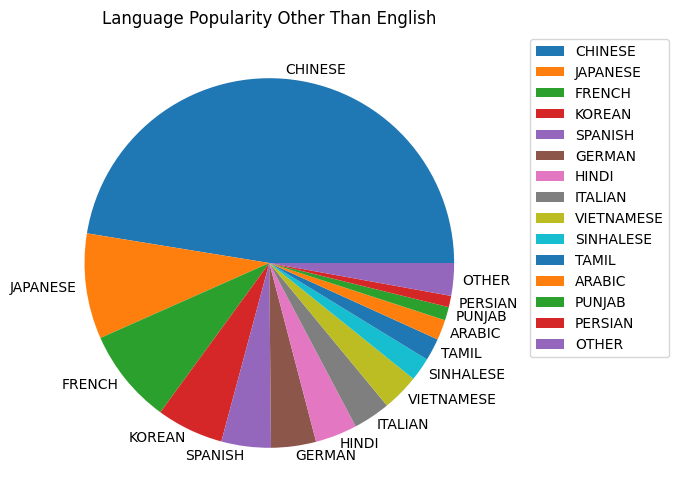

In [121]:
languages = df['Language'].value_counts()[1:].reset_index() # Grabbing every language other than English by popularity


languages_count = languages.loc[languages['count'] > 20] 

smaller_slice = languages.loc[languages['count'] < 20] # separating slices to operate independently 



smaller_slice['Language'] = 'OTHER' # change name of all in the smaller slice to OTHER to group them 



smaller_slice = smaller_slice.groupby('Language')['count'].sum().reset_index() # group and reset index so it is compatible with main languages series




languages = pd.concat([languages_count, smaller_slice]) # concat


languages = languages.reset_index(drop=True) 

plt.figure(figsize=(6,6)) # figure size first

plt.pie(languages['count'],labels=languages['Language'], labeldistance=1.05) # pie chart

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left') # placing legend appropriately 

plt.title('Language Popularity Other Than English') # 

plt.show()


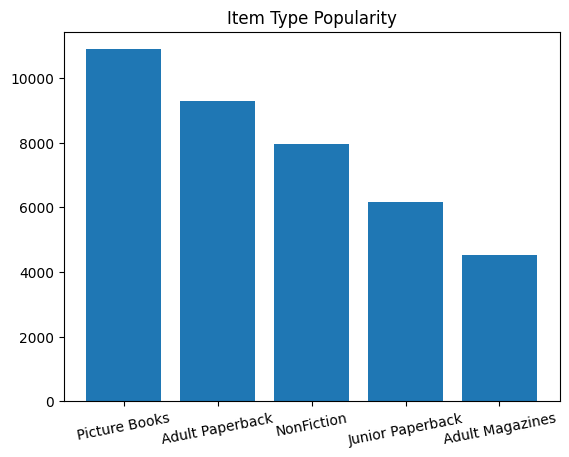

In [129]:
item_types = df['Item Type Code'].value_counts()\
                                .head()\
                                .reset_index()

item_names = ['Picture Books', 'Adult Paperback', 'NonFiction', 'Junior Paperback', 'Adult Magazines'] # Renaming item types for clarity

plt.bar(item_names , item_types['count']) 

plt.title('Item Type Popularity')

plt.tick_params(axis='x', rotation= 11)

plt.show()

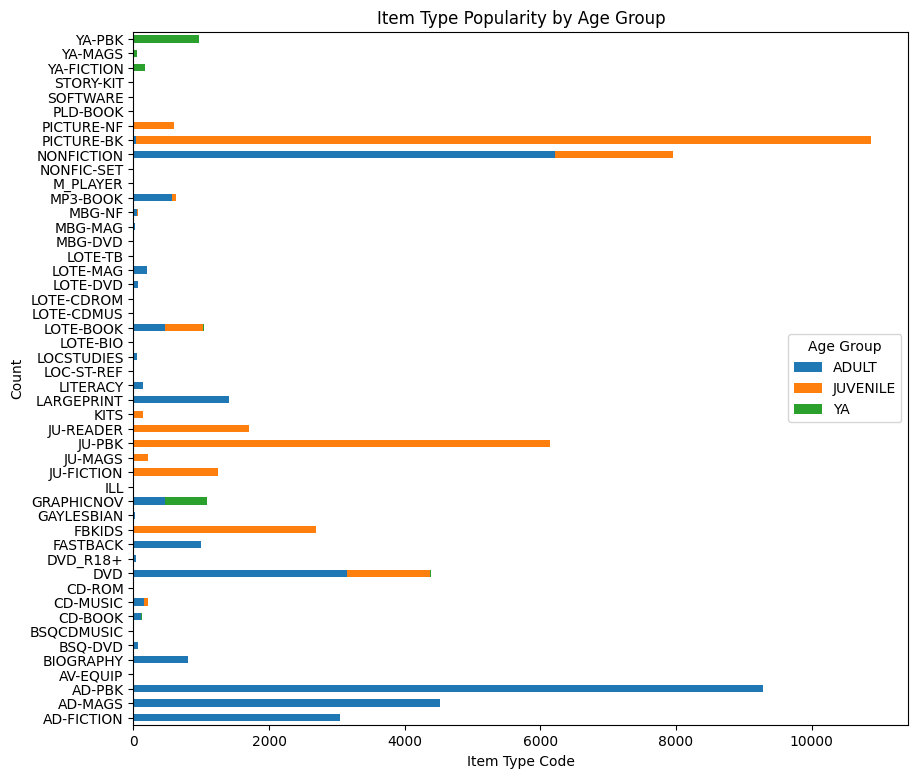

In [125]:
pivot_table = df.pivot_table(index='Item Type Code', 
                             columns='Age', 
                             aggfunc='size', 
                             fill_value=0)

pivot_table = pivot_table.drop(columns='POLICY NOT FOUND', axis=1)


pivot_table.plot(kind='barh', 
                 stacked=True,  # stacked bar plot to represent age distribution per item 
                 figsize=(10, 9))


plt.xlabel('Item Type Code') 
plt.ylabel('Count')
plt.title('Item Type Popularity by Age Group')
plt.legend(title='Age Group', loc='center right') # legend on the right
plt.show()



C:\Users\minec\AppData\Local\Temp\ipykernel_28776\3050531409.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels)


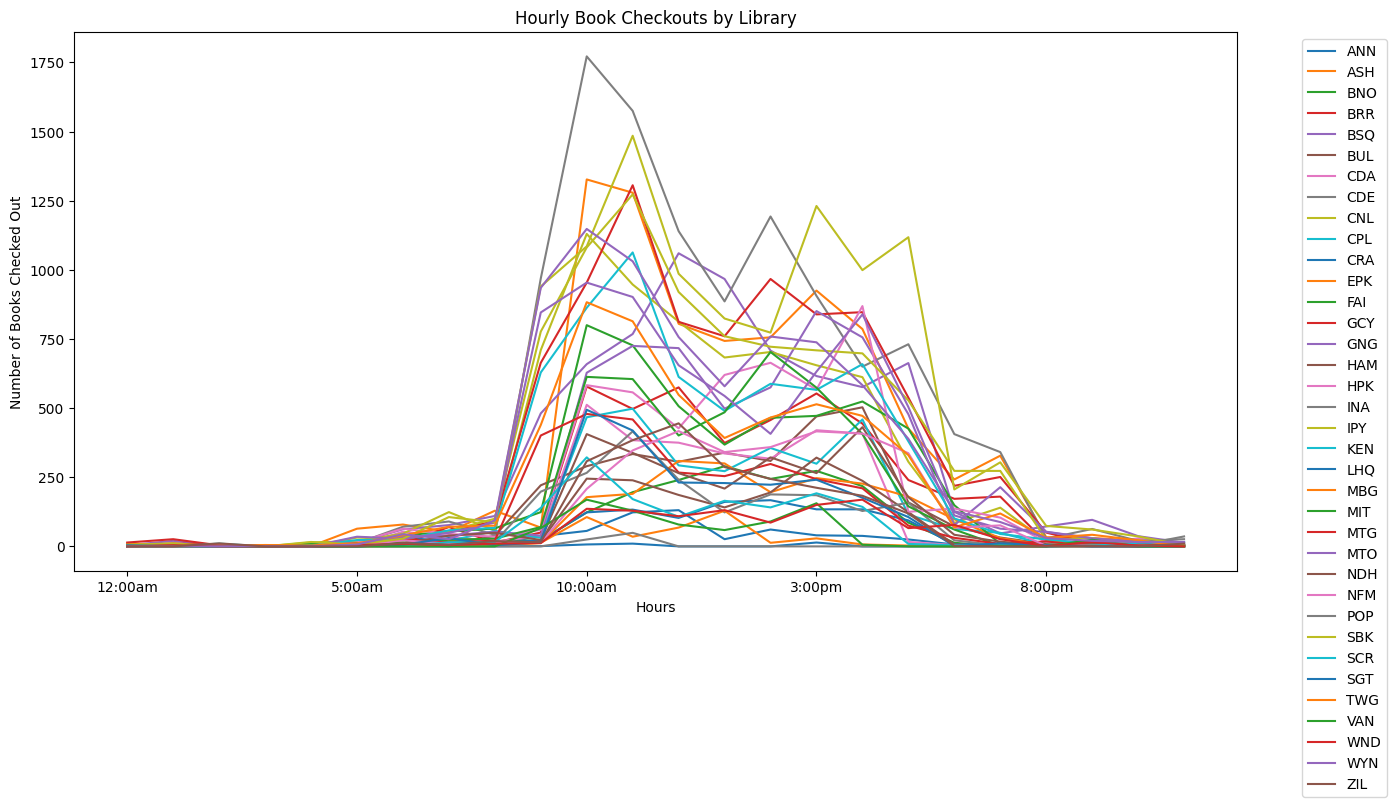

In [15]:

df['Time'] = df['Date'].dt.hour
hourly = df.groupby(['Time', 'Checkout Library']).size().reset_index() # group data by hour and library


hourly = hourly.pivot(index='Time', columns='Checkout Library', values=0).fillna(0) # pivot time as index and libraries as columns


ax = hourly.plot(figsize=(15, 7)) 

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left') # moving legend

plt.xlabel('Hours')
plt.ylabel('Number of Books Checked Out')
plt.title('Hourly Book Checkouts by Library')
labels = [item.get_text() for item in ax.get_xticklabels()]

labels = ['0','12:00am','5:00am','10:00am','3:00pm','8:00pm']

ax.set_xticklabels(labels)

plt.show()


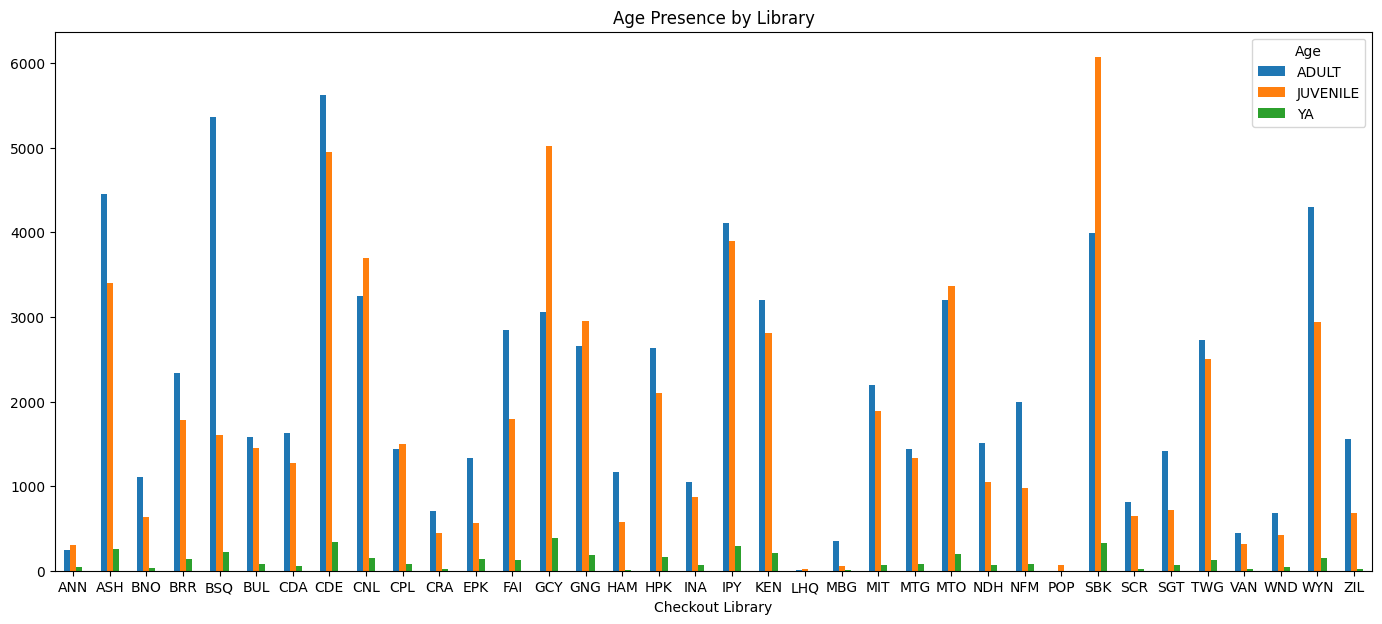

In [123]:
first = df.groupby('Checkout Library')['Age'].value_counts().reset_index() # grouping and counting age group activity by library

pivoting = df.pivot_table(index='Checkout Library', # pivot table to set Age as columns and the counts as values
                          columns='Age', 
                          aggfunc='size')



pivoting = pivoting.drop(columns='POLICY NOT FOUND') # dropping ambiguous column


pivoting.plot(kind='bar', figsize=(17,7)) # long size


plt.title('Age Presence by Library')

plt.xticks(rotation=0)

plt.show()


In [17]:
# PERCENTAGE CHANGES IN CHECKOUT COUNTS FROM JUVENILE

perc_juv_adult = pivoting[['JUVENILE', 'ADULT']].pct_change(axis=1, fill_method= None)
perc_juv_ya = pivoting[['JUVENILE', 'YA']].pct_change(axis=1, fill_method= None)

print(perc_juv_ya.mean())

print('----')
print(perc_juv_adult.mean())

Age
JUVENILE         NaN
YA         -0.926798
dtype: float64
----
Age
JUVENILE         NaN
ADULT       0.472858
dtype: float64
